#**DeBCR: denoising, deblurring, and optical deconvolution using a physics-informed neural network for light microscopy and cryo-ET**

This notebook provides a quick and simple guide for setup and training of the **DeBCR**. The two examples of training/validation data are provided to showcase **DeBCR** training setup and process for denoising task.

The following tasks/datasets are provided as examples:

- **LM: 2D denoising** (files: LM_2D_CARE_X.npz) - low/high exposure confocal dataset of *Schmidtea mediterranea* (`Denoising_Planaria` dataset) from the publication of CARE network applied to fluorescent microscopy data ([Weigert, Schmidt, Boothe et al., Nature Methods, 2018](https://www.nature.com/articles/s41592-018-0216-7)).
- **EM: low-frequency denoising** (files: EM_low_Tomo110_X.npz) - cryoET dataset of *Chlamydomonas reinhardtii* cilia (`Tomo110 dataset`) from the cryo-CARE publication ([Buchholz et al., IEEE (ISBI), 2019](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759519&tag=1)).

Related resources:
- [source code (GitHub)](https://github.com/leeroyhannover/DeBCR)
- [training datasets (Zenodo)](https://zenodo.org/doi/10.5281/zenodo.12626121)

## About DeBCR

**DeBCR** is a physics-informed deep learning model for light and electron microscopy image restorations (deblurring, denoising, and deconvolution). **DeBCR** is implemented based on the original Beylkin-Coifman-Rokhlin (BCR) model, implemented within DNN structure:

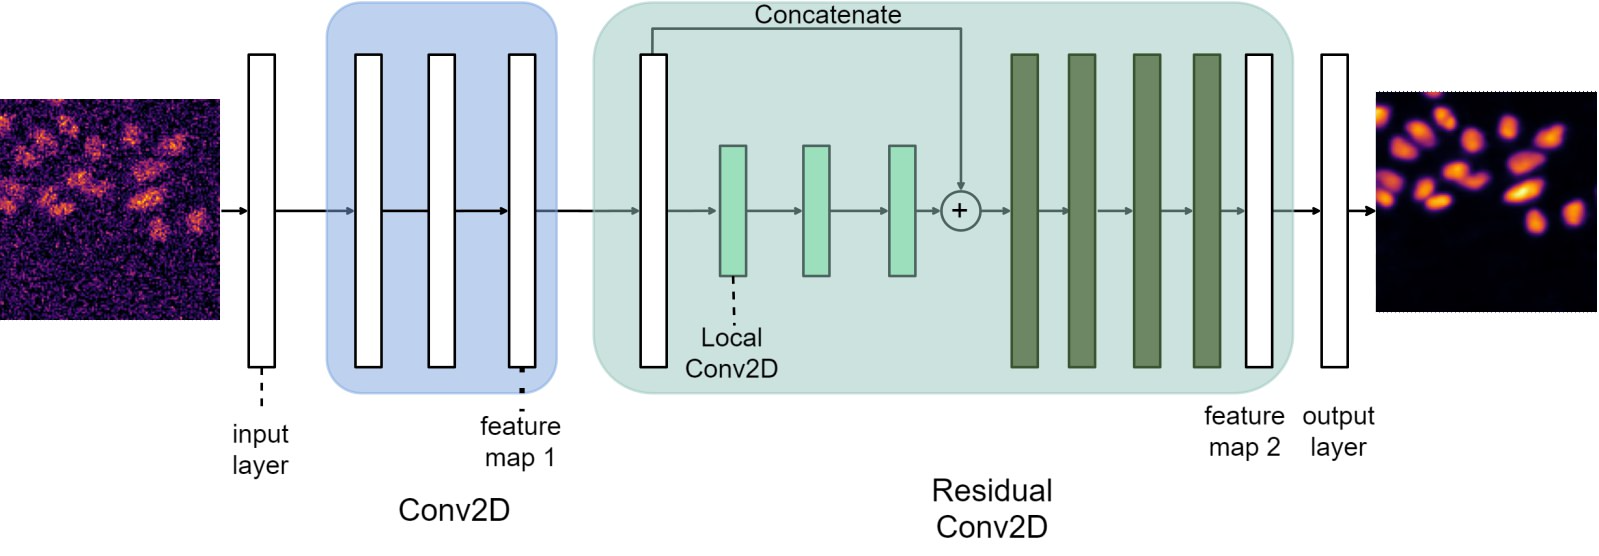

In contrast to the traditional single-stage residual BCR learning process, **DeBCR** integrates feature maps from multiple resolution levels:

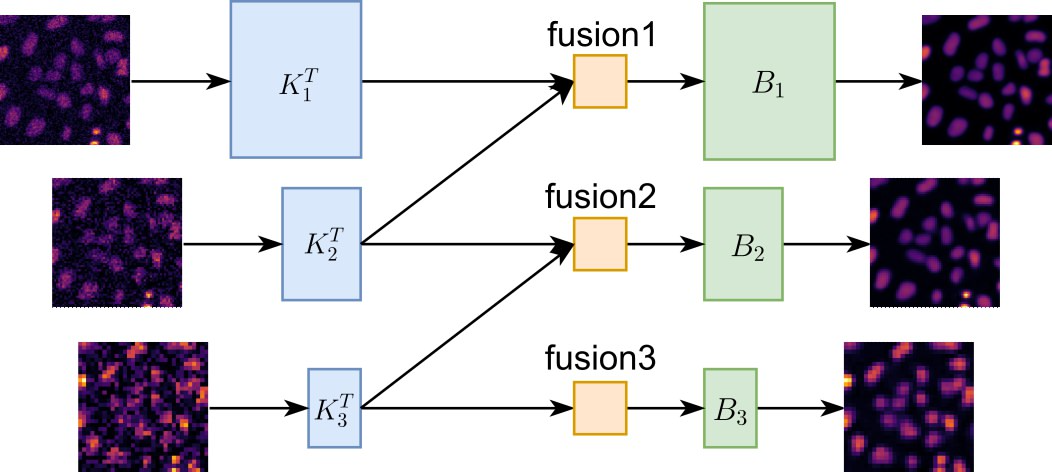

For further details on implementation and benchmarks see our preprint (***in submission***):

Li R., Yushkevich A., Chu X., Kudryashev M., Yakimovich A. Denoising, Deblurring, and optical Deconvolution for cryo-ET and light microscopy with a physics-informed deep neural network DeBCR. in submission*, 2024.

## Usage instructions

**Quick start**

- Copy the notebook to your own google drive by `File` -> `Save a copy in a Drive` and open it
- Hit `Runtime` -> `Run all`

In [ ]:
#@title Setup DeBCR
%%time
import os
import sys

print("cloning DeBCR repository...")

os.system("git clone https://github.com/leeroyhannover/DeBCR.git /content/DeBCR")

sys.path.insert(0,'/content/DeBCR') # to import custom utils

In [ ]:
#@title Fetch provided data

import numpy as np

#@markdown Select below to obtain training data example:
LM_data = True #@param {type:"boolean"}
EM_data = True #@param {type:"boolean"}

if LM_data or EM_data:
  #if not os.path.isfile("DEBCR_EXAMPLE_DATA_READY"):
  print("preparing DeBCR training data example...")
  example_data_dir = "/content/DeBCR/data"
  os.system("mkdir -p " + example_data_dir)

if LM_data:
  example_data_dir_LM = example_data_dir + '/LM'
  if not os.path.isfile(example_data_dir_LM + "/train/LM_2D_train.npz"):
    print("Fetching example LM training data...")
    os.system("mkdir -p " + example_data_dir_LM + "/train")
    os.system("wget https://zenodo.org/records/12626122/files/LM_2D_CARE_train.npz -P " + example_data_dir_LM + "/train")
    print("Done!")
  if not os.path.isfile(example_data_dir_LM + "/val/LM_2D_val.npz"):
    print("Fetching example LM validation data...")
    os.system("mkdir -p " + example_data_dir_LM + "/val")
    os.system("wget https://zenodo.org/records/12626122/files/LM_2D_CARE_val.npz -P " + example_data_dir_LM + "/val")
    print("Done!")
  print("Example LM data located at " + example_data_dir_LM)

def concat_npz(path_raw_npz, filename_npz_list, path_full_npz, filename_concat_npz):
  p = [np.load(path_raw_npz + os.sep + filename_npz) for filename_npz in filename_npz_list]
  p_merged = {}
  for p_i in p:
    [p_merged.update({k: v}) for k, v in p_i.items()]
  np.savez(path_full_npz + os.sep + filename_concat_npz, **p_merged)

if EM_data:
  example_data_dir_EM = example_data_dir + '/EM'
  if not os.path.isfile(example_data_dir_EM + "/train/EM_low_train.npz"):
    print("Fetching example EM training data...")
    os.system("mkdir -p " + example_data_dir_EM + "/train")
    os.system("wget https://zenodo.org/records/12626122/files/EM_low_Tomo110_train.npz -P " + example_data_dir_EM + "/train")
    print("Done!")
  if not os.path.isfile(example_data_dir_EM + "/val/EM_low_val.npz"):
    print("Fetching example EM validation data...")
    os.system("mkdir -p " + example_data_dir_EM + "/val")
    os.system("wget https://zenodo.org/records/12626122/files/EM_low_Tomo110_val.npz -P " + example_data_dir_EM + "/val")
    print("Done!")
  print("Example EM data located at " + example_data_dir_EM)

#  os.system("touch DEBCR_EXAMPLE_DATA_READY")

In [20]:
#@title Access custom data (skip if using provided data)

#@markdown Connect your google-drive, if needed
mount_gdrive = False #@param {type:"boolean"}

#@markdown Provide path to your training data directory:
my_train_data_dir = '/content/gdrive/MyDrive/path/to/data/EM_low/train/' #@param {type:"string"}

#@markdown Provide path to your validation data directory:
my_val_data_dir = '/content/gdrive/MyDrive/path/to/data/EM_low/val/' #@param {type:"string"}

#@markdown Provide path to your configuration YAML file:
my_yaml_data_path = '/content/gdrive/MyDrive/path/to/data/EM_low/EM_low_freq_denoising.yaml' #@param {type:"string"}

#@markdown Your directories are located at
#@markdown - `/content/` - if you directly uploaded it using "Files" panel on the left
#@markdown - `/content/gdrive/MyDrive/` - if you mounted your google-drive

#@markdown P.S. Training and validation data directories should contain only corresponding .npz files!

if mount_gdrive:
  from google.colab import drive
  drive.mount('/content/gdrive')

In [ ]:
#@title Configure and check data

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob
import random
from util.utils import *
from configs.yaml_loader import *
import argparse
from natsort import natsorted

#@markdown Select training/validation data source
data = 'provided' #@param ['provided', 'own']
#@markdown - if *provided* data selected, the paths are set up to auto-fetched data
#@markdown - if *own* data selected, the paths set above will be used

#@markdown Select microscopy type
modality = 'EM' #@param ['LM', 'EM']
#use_own_data = False #@param {type:"boolean"}

if data == 'own':
  config_yaml_path = my_yaml_data_path
  train_data_dir = my_train_data_dir
  val_data_dir = my_val_data_dir
else:
  config_yaml_path = glob.glob("DeBCR/configs/" + modality + "*.yaml")[0]
  train_data_dir = example_data_dir + os.sep + modality + '/train/'
  val_data_dir = example_data_dir + os.sep + modality + '/val/'

print('Selected configuration file path: ' + config_yaml_path)

parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, help="Path to yaml config file")
args = parser.parse_args(["--config", config_yaml_path])
config = get_config(args.config)

# tranining data generation
train_data_list = natsorted(os.listdir(train_data_dir))
train_gen_class = DataGenerator(train_data_dir, train_data_list,config.data['train_batch'], config.data['noise'], config.data['domain'])
train_img_datagen = train_gen_class.imageLoader()

# validation data generation
val_data_list = natsorted(os.listdir(val_data_dir))
val_gen_class = DataGenerator(val_data_dir, val_data_list, config.data['val_batch'], config.data['noise'], config.data['domain'])
val_img_datagen = val_gen_class.imageLoader()

# data sanity check

w_img_temp, o_temp = train_img_datagen.__next__()
print(w_img_temp.shape)

slice_num = random.randint(0, w_img_temp.shape[0]-1)
subShow(w_img_temp[slice_num].squeeze(), o_temp[slice_num].squeeze(), config.data['domain'])
print(slice_num)

In [ ]:
#@title Prepare and check model

from models.DeBCR import *
from util.loss_func import *
from util.metrics import *

model = model_DeBCR()
model.compile(optimizer=config.training['opti'], loss=loss_function_mimo, metrics=[metrics_func_mimo])
print(model.input_shape, model.output_shape) # [(None, 128, 128, 1), (None, 64, 64, 1), (None, 32, 32, 1)]
print(model.summary())

In [ ]:
#@title Train model

if config.data['domain'] == 'LM':
  from trainer_DeBCR import train_model_LM as trainer
elif config.data['domain'] == 'EM':
  from trainer_DeBCR import train_model_EM as trainer
else:
  print('illegal trainer')

model_trained = trainer(config, model, multi_input, loss_function_mimo, metrics_func_mimo, train_img_datagen, val_img_datagen, config.training['visual'])

In [ ]:
#@title Visualize training results

w_img_val_temp, o_val_temp = val_img_datagen.__next__()
w_val_temp_list, o_val_temp_list = multi_input(w_img_val_temp, o_val_temp)

pred_val_list = model_trained.predict(w_val_temp_list)

if config.data['domain'] == 'LM':
    show_grid_LM(pred_val_list[0], w_val_temp_list[0], o_val_temp_list[0])
elif config.data['domain'] == 'EM':
    show_grid_EM(pred_val_list[0], w_val_temp_list[0])
else:
    print('illegal visualizer')